## Tutorial of Patching Patching, Causal Scrubbing

In [1]:
__author__ = "Aryaman Arora and Zhengxuan Wu"
__version__ = "10/04/2023"

### Overview

This tutorial aims to reproduce some of the results in this [notebook](https://github.com/aryamanarora/nano-causal-interventions/blob/main/The%20capital%20of%20France%20is.ipynb) for path patching or causal scrubbing. This library could potentially support other kinds of interventions that were not originally supported by previous works.

### Set-up

In [2]:
import pandas as pd
from models.utils import embed_to_distrib, top_vals, format_token
from models.configuration_alignable_model import AlignableRepresentationConfig, AlignableConfig
from models.alignable_base import AlignableModel
from models.gpt2.modelings_alignable_gpt2 import create_gpt2

%config InlineBackend.figure_formats = ['svg']
from plotnine import ggplot, geom_tile, aes, facet_wrap, theme, element_text, \
                     geom_bar, geom_hline, scale_y_log10


### Factual recall

In [3]:
config, tokenizer, gpt = create_gpt2()

base = "The capital of Spain is"
source = "The capital of Italy is"
inputs = [
    tokenizer(base, return_tensors="pt"),
    tokenizer(source, return_tensors="pt")
]
print(base)
res = gpt(**inputs[0])
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)
print()
print(source)
res = gpt(**inputs[1])
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

loaded model
The capital of Spain is
_Madrid              0.10501296818256378
_the                 0.09496472775936127
_Barcelona           0.07027896493673325
_a                   0.04010061174631119
_now                 0.028243593871593475
_in                  0.027600279077887535
_Spain               0.022992031648755074
_Catalonia           0.018823478370904922
_also                0.01868910901248455
_not                 0.0173567533493042

The capital of Italy is
_Rome                0.15734177827835083
_the                 0.07316122949123383
_Milan               0.04688136279582977
_a                   0.03450017422437668
_now                 0.0320034995675087
_in                  0.023065155372023582
_also                0.022747963666915894
_home                0.01920326240360737
_not                 0.01640525832772255
_Italy               0.015770886093378067


### Patch Patching on Position-aligned Tokens
We path patch on two modules on each layer:
- [1] MLP output (the MLP output will be from another example)
- [2] MHA input (the self-attention module input will be from another module)

In [4]:
def simple_position_config(model_type, intervention_type, layer):
    alignable_config = AlignableConfig(
        alignable_model_type=model_type,
        alignable_representations=[
            AlignableRepresentationConfig(
                layer,             # layer
                intervention_type, # intervention type
                "pos",             # intervention unit
                1                  # max number of unit
            ),
        ],
        alignable_interventions_type="VanillaIntervention",
    )
    return alignable_config

config, tokenizer, gpt = create_gpt2()
base = tokenizer("The capital of Spain is", return_tensors="pt")
sources = [tokenizer("The capital of Italy is", return_tensors="pt")]

loaded model


In [5]:
# should finish within 1 min with a standard 12G GPU
tokens = tokenizer.encode(" Madrid Rome")

data = []
for layer_i in range(gpt.config.n_layer):
    alignable_config = simple_position_config("gpt2", "mlp_output", layer_i)
    alignable = AlignableModel(alignable_config, gpt)
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = alignable(
            base,
            sources,
            {"sources->base": ([[[pos_i]]], [[[pos_i]]])}
        )
        distrib = embed_to_distrib(
            gpt, counterfactual_outputs.last_hidden_state, 
            logits=False
        )
        for token in tokens:
            data.append({
                'token': format_token(tokenizer, token),
                'prob': float(distrib[0][-1][token]),
                'layer': f"f{layer_i}",
                'pos': pos_i,
                'type': "mlp_output"
            })
            
    alignable_config = simple_position_config("gpt2", "attention_input", layer_i)
    alignable = AlignableModel(alignable_config, gpt)
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = alignable(
            base,
            sources,
            {"sources->base": ([[[pos_i]]], [[[pos_i]]])}
        )
        distrib = embed_to_distrib(
            gpt, counterfactual_outputs.last_hidden_state, 
            logits=False
        )
        for token in tokens:
            data.append({
                'token': format_token(tokenizer, token),
                'prob': float(distrib[0][-1][token]),
                'layer': f"a{layer_i}",
                'pos': pos_i,
                'type': "attention_input"
            })
df = pd.DataFrame(data)

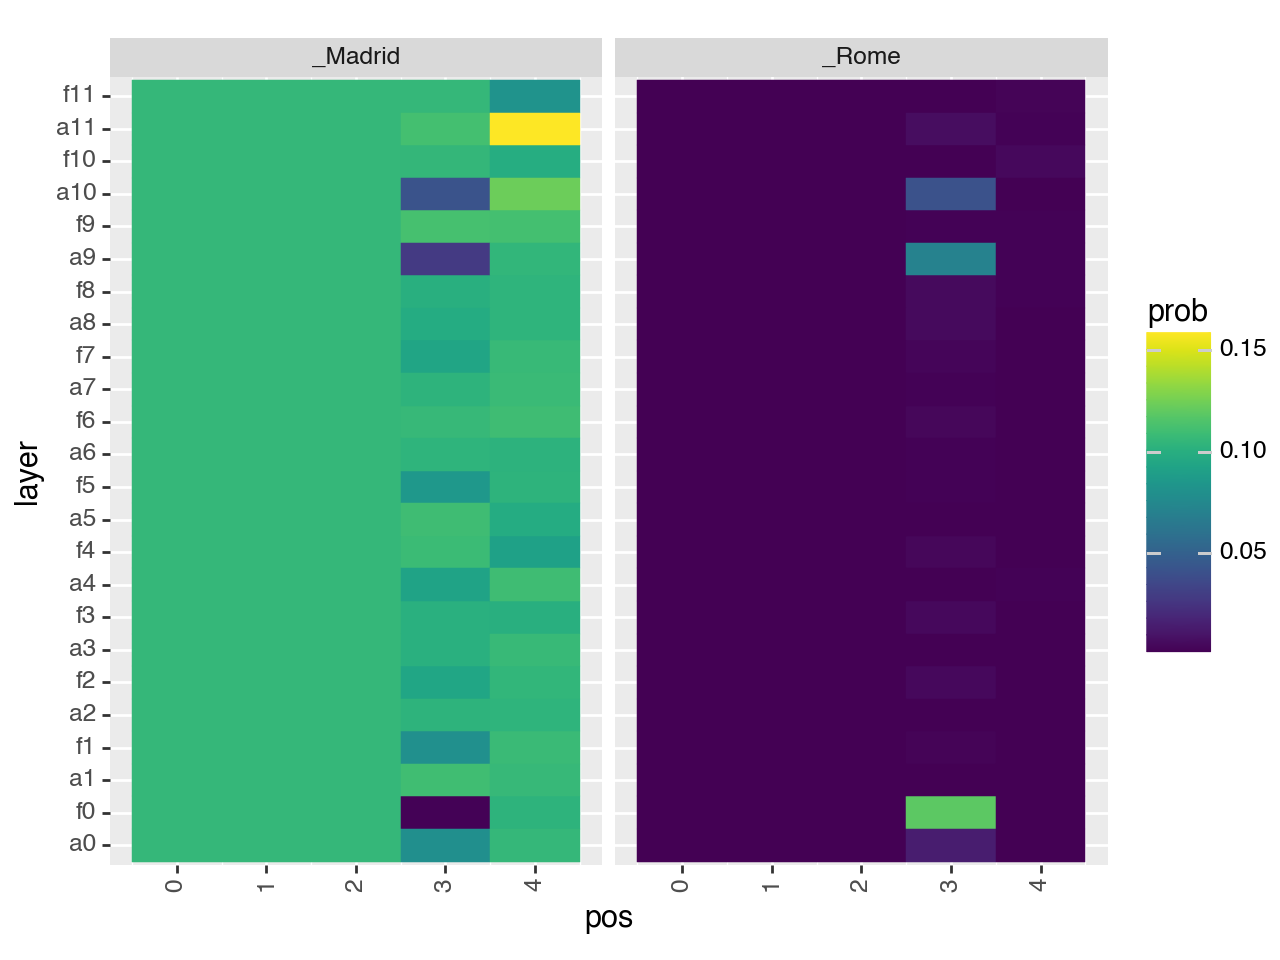

In [7]:
df['layer'] = df['layer'].astype('category')
df['token'] = df['token'].astype('category')
nodes = []
for l in range(gpt.config.n_layer - 1, -1, -1):
    nodes.append(f'f{l}')
    nodes.append(f'a{l}')
df['layer'] = pd.Categorical(df['layer'], categories=nodes[::-1], ordered=True)

g = (ggplot(df) + geom_tile(aes(x='pos', y='layer', fill='prob', color='prob')) +
     facet_wrap("~token") + theme(axis_text_x=element_text(rotation=90)))
print(g)

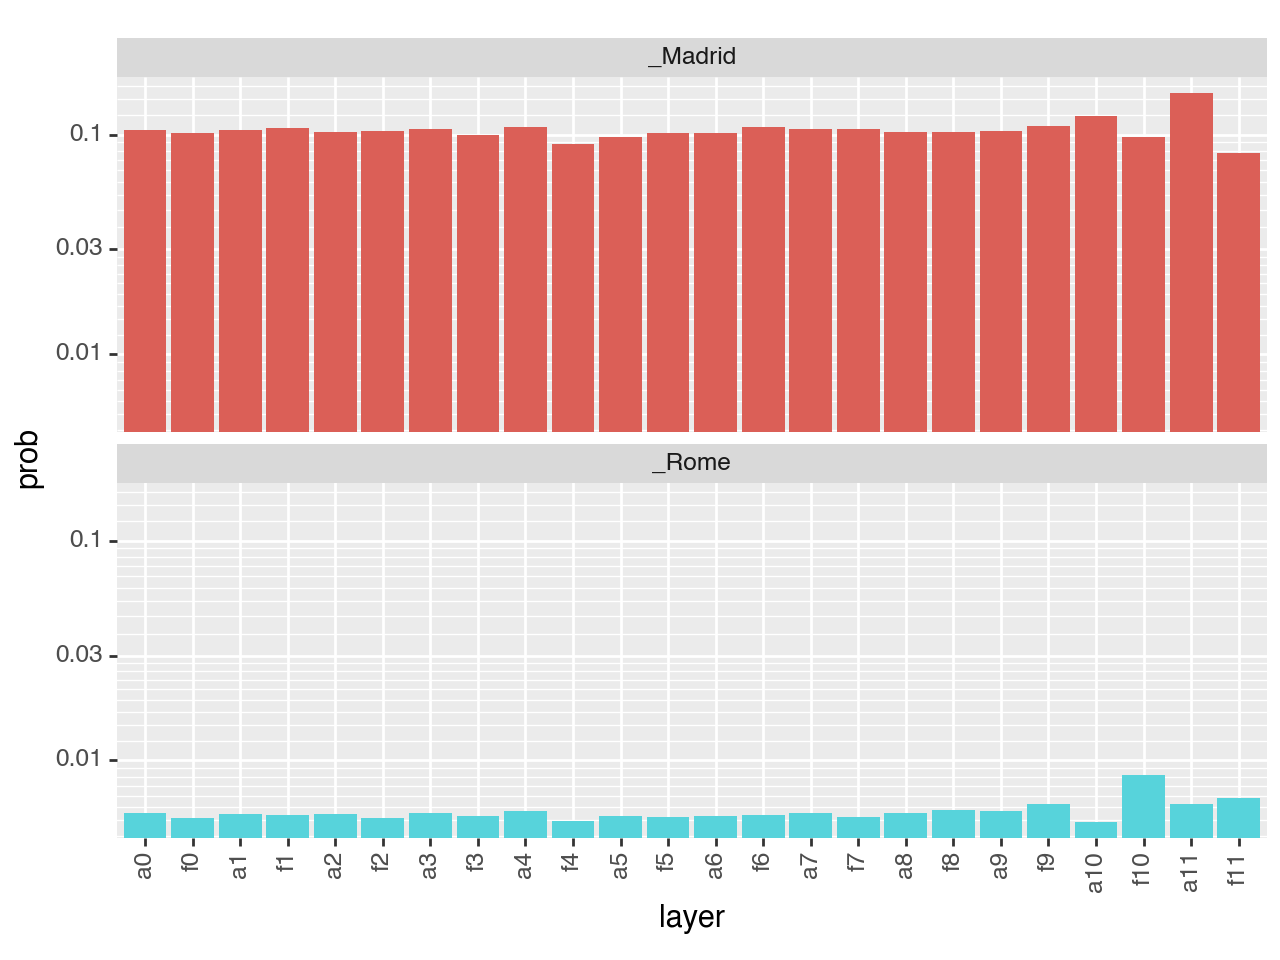

In [8]:
filtered = df
filtered = filtered[filtered['pos'] == 4]
g = (ggplot(filtered) + geom_bar(aes(x='layer', y='prob', fill='token'), stat='identity')
         + theme(axis_text_x=element_text(rotation=90), legend_position='none') + scale_y_log10()
         + facet_wrap("~token", ncol=1))
print(g)